<a href="https://colab.research.google.com/github/dikshetha/Plant_disease_detection/blob/main/Plant_Disease_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


!pip install keras

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import save_model
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,GlobalAvgPool2D,GlobalMaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Assuming your images are in a folder named 'images' in the root of your Google Drive
image_folder_path = '/content/drive/MyDrive/color'

# List files in the folder
import os
image_files = os.listdir(image_folder_path)
print("Image files:", image_files)

Image files: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [ ]:
data = '/content/drive/MyDrive/color/'

images = []
import os

for dirname, _, filenames in os.walk(data):
    for filename in filenames:
        file_name, file_extension = os.path.splitext(filename)
        if file_extension.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
            image_path = os.path.join(dirname, filename)
            images.append(image_path)

In [ ]:
images[:5]

['/content/drive/MyDrive/color/Grape___healthy/1abe34b9-186b-4a90-a3a3-855005ff50f5___Mt.N.V_HL 9033.JPG',
 '/content/drive/MyDrive/color/Grape___healthy/1c3b3f51-d8c9-4bc5-899c-dd50e107f074___Mt.N.V_HL 6027.JPG',
 '/content/drive/MyDrive/color/Grape___healthy/1c13c447-4d2d-4eac-9835-705d952b09d6___Mt.N.V_HL 9128.JPG',
 '/content/drive/MyDrive/color/Grape___healthy/2211cfa2-311c-41f0-aba5-9bdef8037f20___Mt.N.V_HL 6051.JPG',
 '/content/drive/MyDrive/color/Grape___healthy/1c453594-a071-422c-a733-49aa167bac99___Mt.N.V_HL 6118.JPG']

In [ ]:
len(images)

1202

In [ ]:
class_values = []

for i in images:
    split = i.split('/')[-2]  # Use '/' as the path separator
    class_values.append(split)


In [ ]:
class_values[:10]

['Grape___healthy',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___healthy']

In [ ]:
len(class_values)

1202

In [ ]:
temp = list(zip(images,class_values))
random.shuffle(temp)
images, class_values = zip(*temp)
data = pd.DataFrame(list(zip(images, class_values)), columns=['image_path', 'class_label'])

In [ ]:
data

,image_path,class_label
0,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
2,/content/drive/MyDrive/color/Grape___healthy/1...,Grape___healthy
3,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
4,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
...,...,...
1197,/content/drive/MyDrive/color/Grape___healthy/0...,Grape___healthy
1198,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1199,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1200,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


In [ ]:
data.class_label.value_counts()

Grape___Leaf_blight_(Isariopsis_Leaf_Spot)    1076
Grape___healthy                                126
Name: class_label, dtype: int64

<ipython-input-21-1385bd0b454c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="class_label", data=data, palette=sns.color_palette("cubehelix", 4))
<ipython-input-21-1385bd0b454c>:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.countplot(x="class_label", data=data, palette=sns.color_palette("cubehelix", 4))


Text(0.5, 0, 'Class_label')

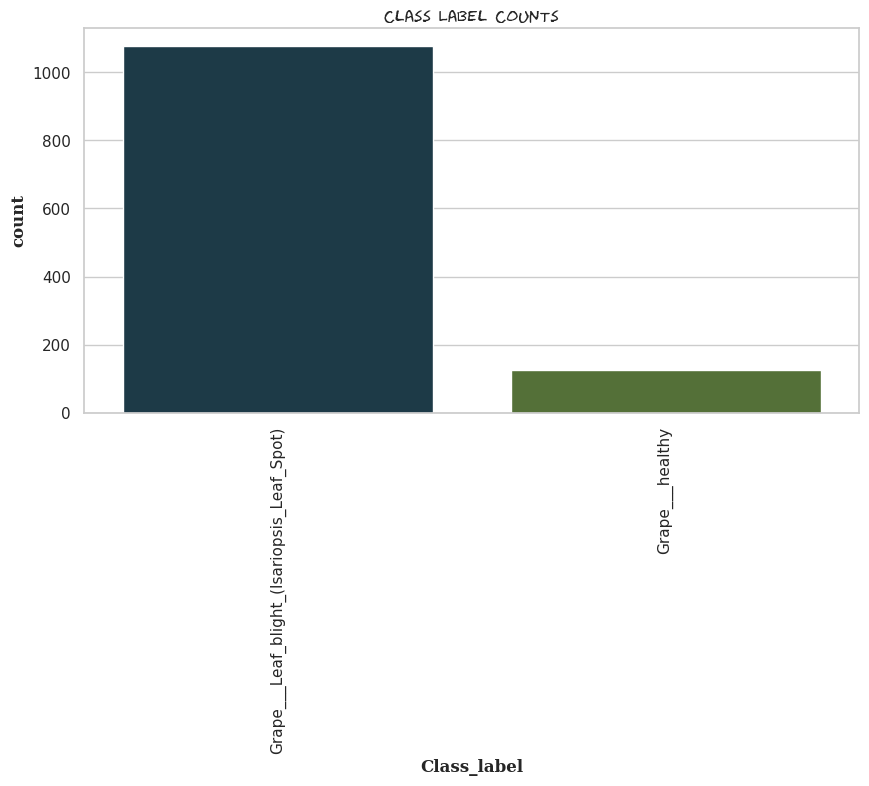

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="class_label", data=data, palette=sns.color_palette("cubehelix", 4))
plt.xticks(rotation=90)
plt.title("Class Label Counts", {"fontname":"fantasy", "fontweight":"bold", "fontsize":"medium"})
plt.ylabel("count", {"fontname": "serif", "fontweight":"bold"})
plt.xlabel("Class_label", {"fontname": "serif", "fontweight":"bold"})

In [ ]:
data['class_label']

0       Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1       Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
2                                  Grape___healthy
3       Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
4       Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
                           ...                    
1197                               Grape___healthy
1198    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1199    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1200    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1201    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Name: class_label, Length: 1202, dtype: object

In [ ]:
class_names = list(data['class_label'])
class_names

['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape

In [ ]:
def resize_image(img):
    file = cv2.imread(img)
    resized = cv2.resize(file, (48,48), interpolation = cv2.INTER_AREA)
    resized= np.array(resized)
    image = np.reshape(resized,[1,48,48,3])
    return resized

In [ ]:
data.shape

(1202, 2)

In [ ]:
data[:10]

,image_path,class_label
0,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
2,/content/drive/MyDrive/color/Grape___healthy/1...,Grape___healthy
3,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
4,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
5,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
6,/content/drive/MyDrive/color/Grape___healthy/2...,Grape___healthy
7,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
8,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
9,/content/drive/MyDrive/color/Grape___Leaf_blig...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


In [ ]:
images=[resize_image(img) for img in data['image_path']]

In [ ]:
images = []
for i in data['image_path']:
    file_name, file_extension = os.path.splitext(i)
    if file_extension == '.db':
        print(file_name)
    else:
        app = resize_image(i)
        images.append(app)

In [ ]:
len(images)

1202

In [ ]:
data['class_label'][:15]

0     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
2                                Grape___healthy
3     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
4     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
5     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
6                                Grape___healthy
7     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
8     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
9     Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
10    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
11    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
12    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
13    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14                               Grape___healthy
Name: class_label, dtype: object

In [ ]:
class_names = list(data['class_label'])
class_names

['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape

In [ ]:
images[0].shape

(48, 48, 3)

Text(0.5, 1.0, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)')

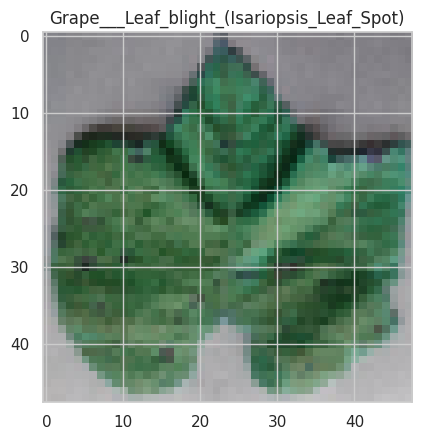

In [ ]:
plt.imshow(images[15])
plt.title(class_values[15])

In [ ]:
images = np.array(images)
images.shape

(1202, 48, 48, 3)

In [ ]:
enc = LabelBinarizer()
y = enc.fit_transform(data['class_label'])

In [ ]:
enc.classes_

array(['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy'],
      dtype='<U42')

In [ ]:
data['class_label'][:10]

0    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
1    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
2                               Grape___healthy
3    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
4    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
5    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
6                               Grape___healthy
7    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
8    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
9    Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Name: class_label, dtype: object

In [ ]:
y[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

IndexError: list index out of range

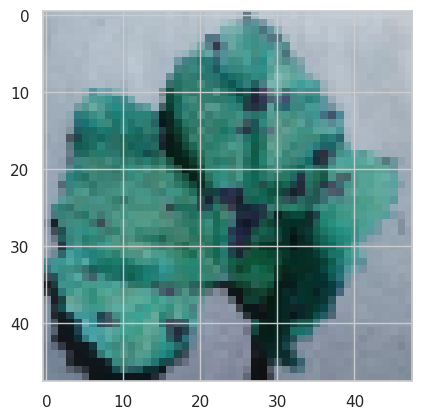

In [ ]:
plt.imshow(images[1111])
plt.title(class_names[5000])

In [ ]:
y = np.array(y)

In [ ]:
y.shape

(11095, 12)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=42)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7766, 48, 48, 3), (7766, 12), (3329, 48, 48, 3), (3329, 12))

In [ ]:
#PLAIN CNN MODEL

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', batch_input_shape = (batch_size,48, 48, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 64)        36928     
                                                      

In [ ]:
from tensorflow.keras.optimizers import RMSprop

opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])



In [ ]:
images.shape

(11095, 48, 48, 3)

In [ ]:
cnn= model.fit(x_train, y_train, epochs = 50, batch_size = 256)

Epoch 1/50
31/31 [==============================] - 206s 6s/step - loss: 4.0085 - accuracy: 0.1947
Epoch 2/50
31/31 [==============================] - 197s 6s/step - loss: 2.2121 - accuracy: 0.2633
Epoch 3/50
31/31 [==============================] - 194s 6s/step - loss: 2.1305 - accuracy: 0.2841
Epoch 4/50
31/31 [==============================] - 196s 6s/step - loss: 2.0510 - accuracy: 0.3079
Epoch 5/50
31/31 [==============================] - 193s 6s/step - loss: 1.8192 - accuracy: 0.3998
Epoch 6/50
31/31 [==============================] - 195s 6s/step - loss: 1.6448 - accuracy: 0.4307
Epoch 7/50
31/31 [==============================] - 195s 6s/step - loss: 1.4726 - accuracy: 0.5040
Epoch 8/50
31/31 [==============================] - 194s 6s/step - loss: 1.5853 - accuracy: 0.5046
Epoch 9/50
31/31 [==============================] - 196s 6s/step - loss: 1.3197 - accuracy: 0.5531
Epoch 10/50
31/31 [==============================] - 194s 6s/step - loss: 1.2463 - accuracy: 0.6137
Epoch 11/

105/105 [==============================] - 21s 201ms/step


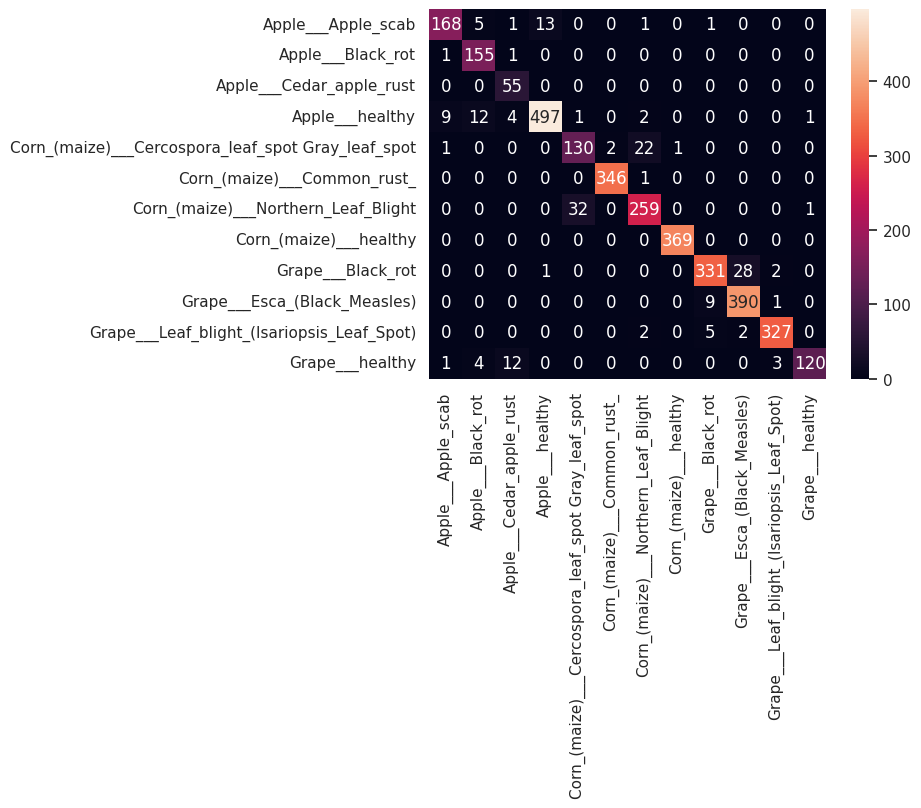

In [ ]:
class_names = enc.classes_
df_heatmap = pd.DataFrame(confusion_matrix(np.argmax((model.predict(x_test)),axis = 1),np.argmax(y_test,axis=1)),columns = class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
cnn_train_score = model.evaluate(x_train, y_train, verbose=0)
print('train accuracy:', cnn_train_score[1])

train accuracy: 0.9732165932655334


In [ ]:
cnn_test_score = model.evaluate(x_test, y_test, verbose=0)
print('test accuracy:', cnn_test_score[1])

test accuracy: 0.945328950881958


1/1 [==============================] - 0s 29ms/step


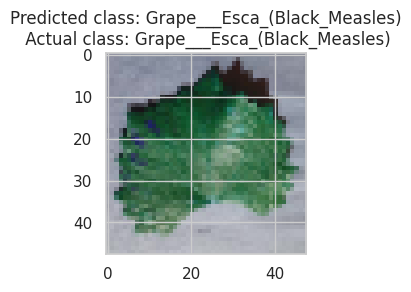

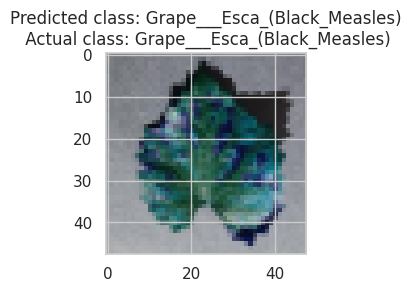

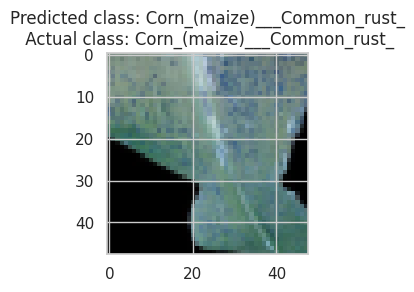

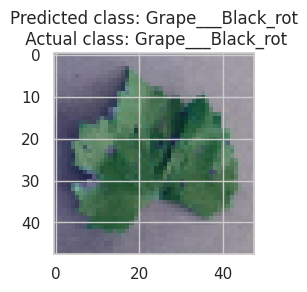

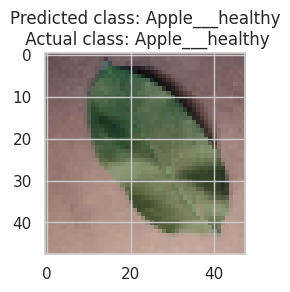

In [ ]:
for i in range(5):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  pred = np.argmax(model.predict(np.array([x_test[i]]))[0])
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  plt.imshow(x_test[i])

In [ ]:
from keras.preprocessing.image import img_to_array

1/1 [==============================] - 0s 132ms/step
Predicted class:Corn_(maize)___Northern_Leaf_Blight


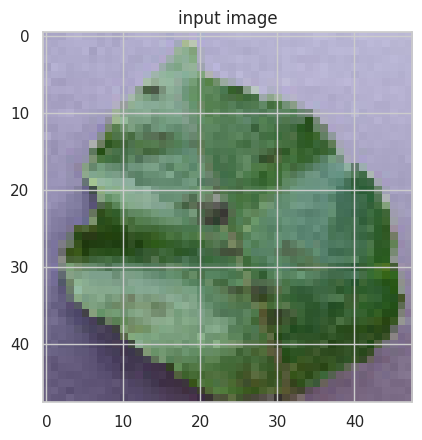

In [ ]:
path = r'/content/drive/MyDrive/color/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'
img = image.load_img(path, target_size=(48,48) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print("Predicted class:{}".format(enc.classes_[pred]))

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

In [ ]:
cnn.history

{'loss': [3.0476930141448975,
  2.1412031650543213,
  2.144420623779297,
  2.1114189624786377,
  2.0949082374572754,
  2.0909676551818848,
  2.0456976890563965,
  1.967344880104065,
  1.8154312372207642,
  1.5938260555267334],
 'accuracy': [0.19005922973155975,
  0.24645891785621643,
  0.2481328845024109,
  0.24285346269607544,
  0.2514808177947998,
  0.2719546854496002,
  0.3098120093345642,
  0.3466391861438751,
  0.3790883421897888,
  0.4379345774650574]}

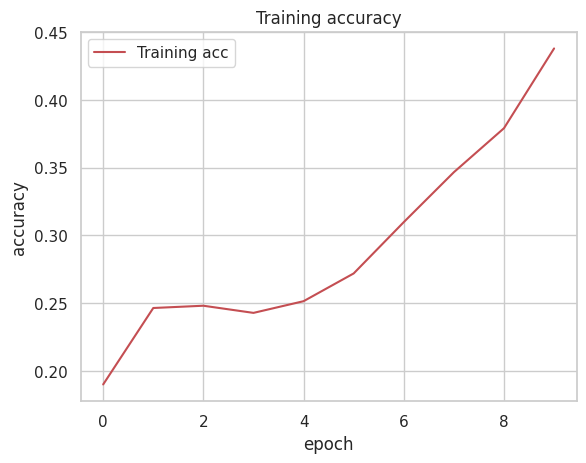

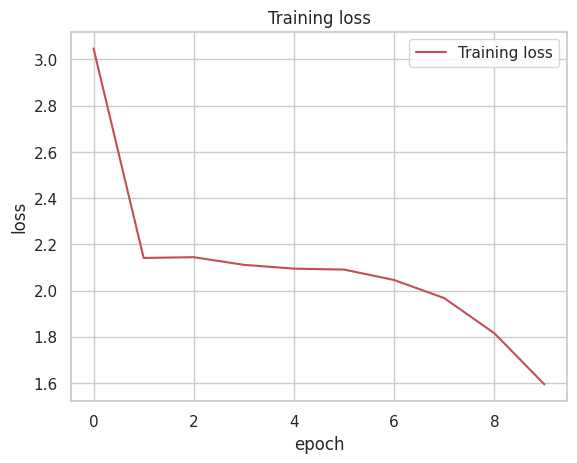

In [ ]:
acc = cnn.history['accuracy']
loss = cnn.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(48,48,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf

In [ ]:
model_1 = Sequential()
model_1.add(vgg)
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(12, activation='softmax'))

In [ ]:
tf.keras.models.save_model(model_1, file_name)

# New section

In [ ]:
from keras.optimizers import Adam, RMSprop

opt = Adam(learning_rate=0.001)
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

model_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
his2= model_1.fit(x_train, y_train, epochs = 50, validation_data = (x_test,y_test),batch_size = 256)

Epoch 1/50
31/31 [==============================] - 1067s 34s/step - loss: 9200.8320 - accuracy: 0.1071 - val_loss: 2.4691 - val_accuracy: 0.1024
Epoch 2/50
31/31 [==============================] - 1076s 35s/step - loss: 2.4588 - accuracy: 0.1190 - val_loss: 2.4517 - val_accuracy: 0.1024
Epoch 3/50
31/31 [==============================] - 1087s 35s/step - loss: 2.4389 - accuracy: 0.1319 - val_loss: 2.4326 - val_accuracy: 0.1532
Epoch 4/50
31/31 [==============================] - 1084s 35s/step - loss: 2.4189 - accuracy: 0.1328 - val_loss: 2.4143 - val_accuracy: 0.1532
Epoch 5/50
31/31 [==============================] - 1087s 35s/step - loss: 2.4003 - accuracy: 0.1398 - val_loss: 2.4005 - val_accuracy: 0.1532
Epoch 6/50
31/31 [==============================] - 1089s 35s/step - loss: 2.3886 - accuracy: 0.1443 - val_loss: 2.3933 - val_accuracy: 0.1532
Epoch 7/50
31/31 [==============================] - 1090s 35s/step - loss: 2.3831 - accuracy: 0.1473 - val_loss: 2.3908 - val_accuracy: 0.1

In [ ]:
his2.history

{'loss': [30086.685546875,
  2.4642627239227295,
  2.448902130126953,
  2.435636281967163,
  2.4216456413269043,
  2.409449577331543,
  2.3978638648986816,
  2.3897948265075684,
  2.3827974796295166,
  2.378553867340088],
 'accuracy': [0.13816213607788086,
  0.15130816400051117,
  0.1511792689561844,
  0.15143704414367676,
  0.1511792689561844,
  0.15130816400051117,
  0.1511792689561844,
  0.15130816400051117,
  0.15130816400051117,
  0.15130816400051117],
 'val_loss': [2.4730849266052246,
  2.459810972213745,
  2.4474880695343018,
  2.435917377471924,
  2.4245076179504395,
  2.415668249130249,
  2.4085850715637207,
  2.403972625732422,
  2.401599407196045,
  2.4010062217712402],
 'val_accuracy': [0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988,
  0.14161154627799988]}

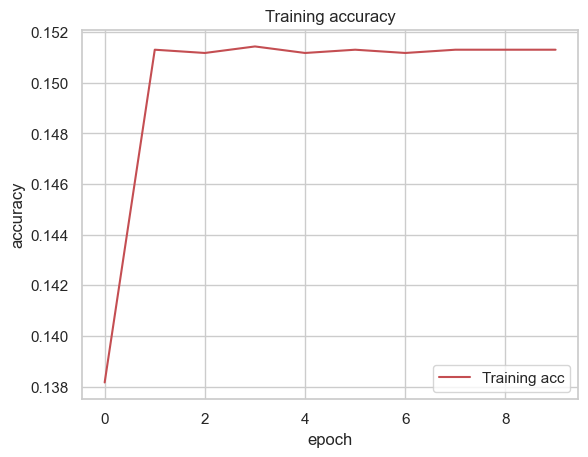

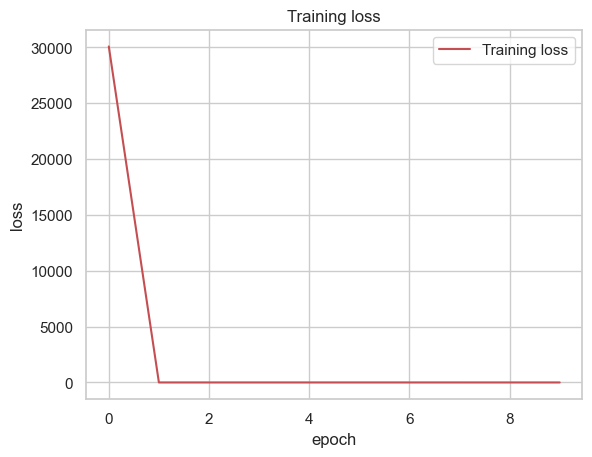

In [ ]:
acc = his2.history['accuracy']
loss = his2.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model_1_score = model_1.evaluate(x_train, y_train, verbose=0)
print('train accuracy:', model_1_score[1])

train accuracy: 0.15130816400051117


In [ ]:
model_1_test_score = model_1.evaluate(x_test, y_test, verbose=0)
print('test accuracy:', model_1_score[1])

test accuracy: 0.15130816400051117


1/1 [==============================] - 0s 47ms/step


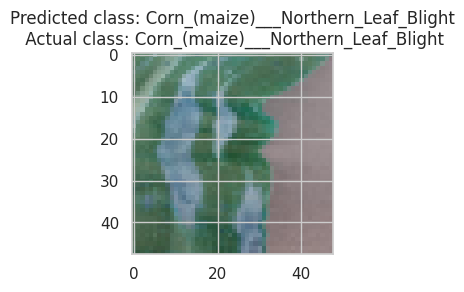

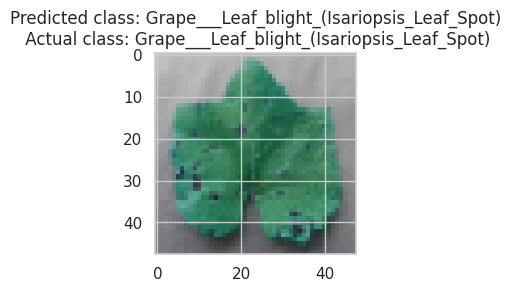

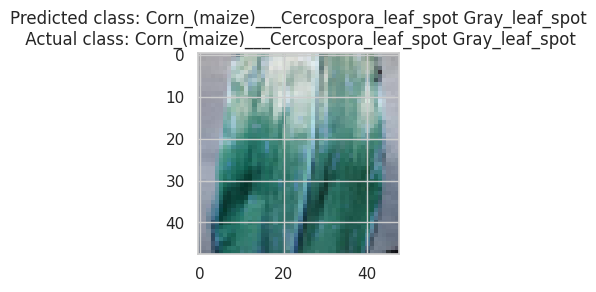

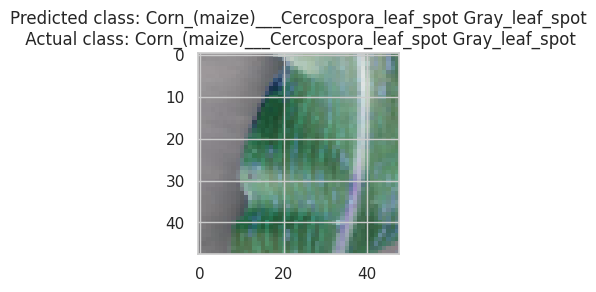

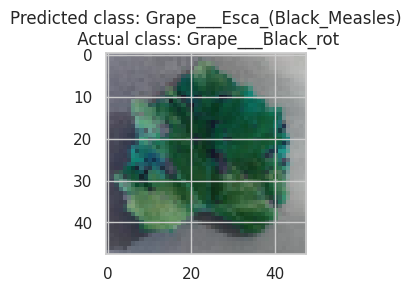

In [ ]:
for i in range(5):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  pred = np.argmax(model_1.predict(np.array([x_test[i]]))[0])
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  plt.imshow(x_test[i])

1/1 [==============================] - 0s 324ms/step
Number of classes: 12
Predicted class index: 9


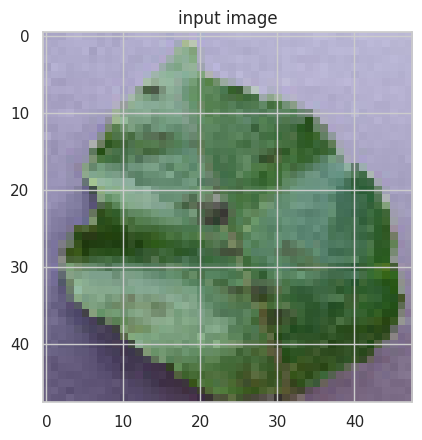

In [ ]:
path = r'/content/drive/MyDrive/color/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'
img = image.load_img(path, target_size=(48,48) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model_1.predict(input_arr))
print("Number of classes:", len(enc.classes_))


print("Predicted class index:", pred)

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

In [ ]:
mob = MobileNetV2(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mob.trainable = False

In [ ]:
mob_model = Sequential()
mob_model.add(mob)
mob_model.add(Flatten())
mob_model.add(Dense(12, activation='relu'))
mob_model.add(Dropout(0.2))
mob_model.add(Dense(12, activation='softmax'))
mob_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_8 (Dense)             (None, 12)                61452     
                                                                 
 dropout_13 (Dropout)        (None, 12)                0         
                                                                 
 dense_9 (Dense)             (None, 12)                156       
                                                                 
Total params: 2319592 (8.85 MB)
Trainable params: 61608 (240.66 KB)
Non-trainable params: 2257984 (8.61 MB)
____________

In [ ]:
opt = Adam(lr=0.001)
mob_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
mob_his = mob_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=128)

Epoch 1/50
61/61 [==============================] - 29s 389ms/step - loss: 2.1815 - accuracy: 0.2579 - val_loss: 1.8801 - val_accuracy: 0.3833
Epoch 2/50
61/61 [==============================] - 22s 368ms/step - loss: 1.8062 - accuracy: 0.3741 - val_loss: 1.5494 - val_accuracy: 0.5245
Epoch 3/50
61/61 [==============================] - 18s 291ms/step - loss: 1.5374 - accuracy: 0.5008 - val_loss: 1.2848 - val_accuracy: 0.5843
Epoch 4/50
61/61 [==============================] - 18s 305ms/step - loss: 1.4055 - accuracy: 0.5189 - val_loss: 1.1971 - val_accuracy: 0.5933
Epoch 5/50
61/61 [==============================] - 19s 307ms/step - loss: 1.3178 - accuracy: 0.5366 - val_loss: 1.1568 - val_accuracy: 0.6074
Epoch 6/50
61/61 [==============================] - 18s 292ms/step - loss: 1.2580 - accuracy: 0.5471 - val_loss: 1.0680 - val_accuracy: 0.6233
Epoch 7/50
61/61 [==============================] - 19s 308ms/step - loss: 1.2216 - accuracy: 0.5485 - val_loss: 1.0226 - val_accuracy: 0.6473

105/105 [==============================] - 7s 54ms/step


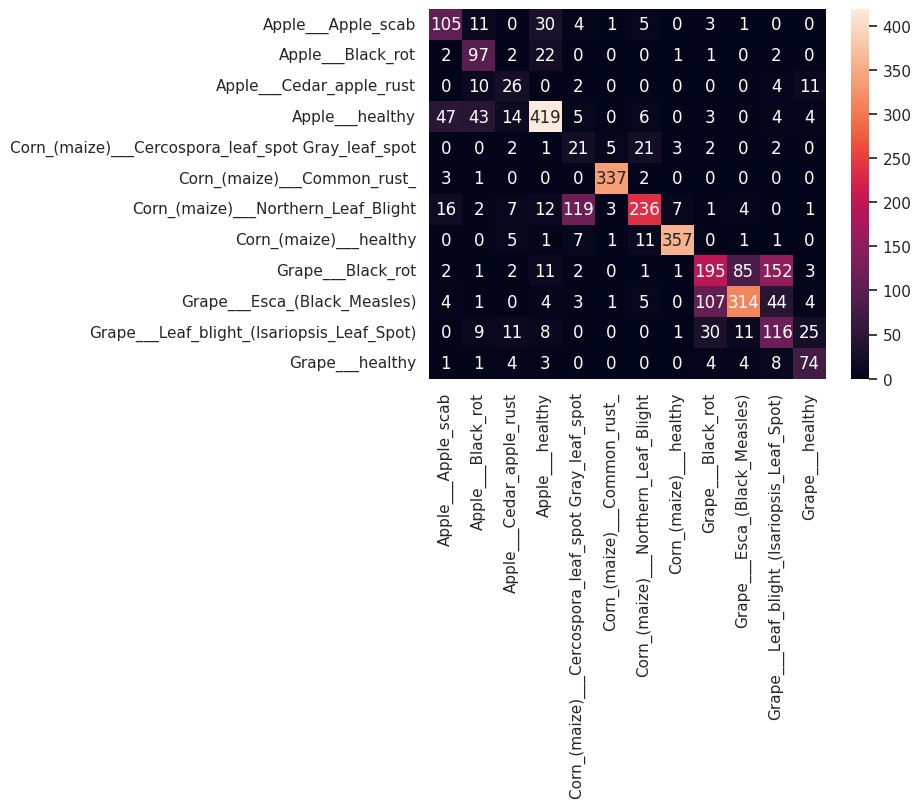

In [ ]:
class_names = enc.classes_
df_heatmap = pd.DataFrame(confusion_matrix(np.argmax((mob_model.predict(x_test)),axis = 1),np.argmax(y_test,axis=1)),columns = class_names, index = class_names)
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

In [ ]:
mob_his.history

{'loss': [2.1814770698547363,
  1.8061562776565552,
  1.5374045372009277,
  1.4055418968200684,
  1.3177906274795532,
  1.2579538822174072,
  1.2215603590011597,
  1.1836423873901367,
  1.1740362644195557,
  1.1142007112503052,
  1.097204327583313,
  1.0753601789474487,
  1.0557283163070679,
  1.0396841764450073,
  1.0226562023162842,
  1.0079597234725952,
  1.0033226013183594,
  0.9879002571105957,
  0.9865577220916748,
  0.9563143849372864,
  0.9597633481025696,
  0.9475805163383484,
  0.9304608702659607,
  0.9395731091499329,
  0.9105744957923889,
  0.9243060946464539,
  0.9181195497512817,
  0.9011549949645996,
  0.8906770348548889,
  0.9079853892326355,
  0.8747243881225586,
  0.867387592792511,
  0.8523551821708679,
  0.8615638613700867,
  0.851382851600647,
  0.8615458011627197,
  0.8542277216911316,
  0.8447720408439636,
  0.8314561247825623,
  0.8281673789024353,
  0.8274988532066345,
  0.8193846940994263,
  0.8222639560699463,
  0.806132435798645,
  0.8100978136062622,
  0.79

In [ ]:
mob_train_score = mob_model.evaluate(x_train, y_train, verbose=0)
print('train accuracy:', mob_train_score[1])

train accuracy: 0.8320885896682739


In [ ]:
mob_test_score = mob_model.evaluate(x_train, y_train, verbose=0)
print('test accuracy:', mob_test_score[1])

test accuracy: 0.8320885896682739


1/1 [==============================] - 0s 26ms/step


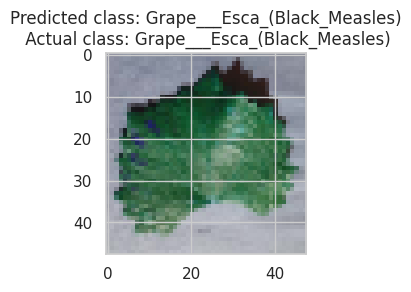

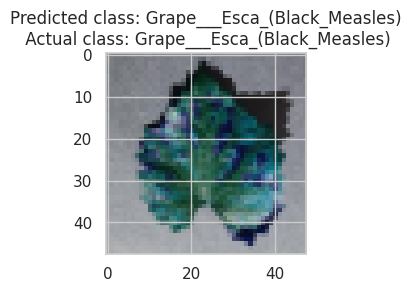

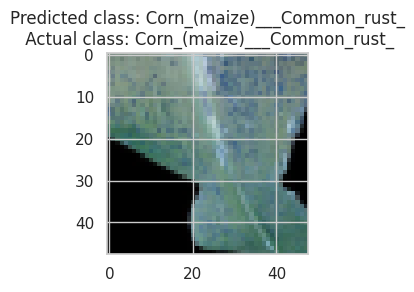

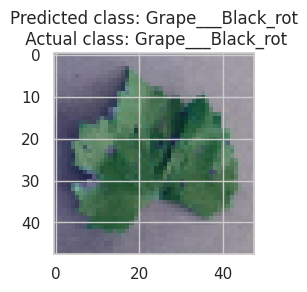

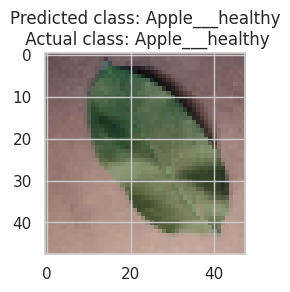

In [ ]:
for i in range(5):
  plt.figure(figsize=(15,15))
  plt.subplot(4,5,i+1)
  pred = np.argmax(model.predict(np.array([x_test[i]]))[0])
  act = np.argmax(y_test[i])
  plt.title("Predicted class: {}\n Actual class: {}".format(enc.classes_[pred],enc.classes_[act]))
  plt.imshow(x_test[i])

In [ ]:
from keras.preprocessing.image import img_to_array


1/1 [==============================] - 1s 880ms/step
Predicted class:Apple___Apple_scab


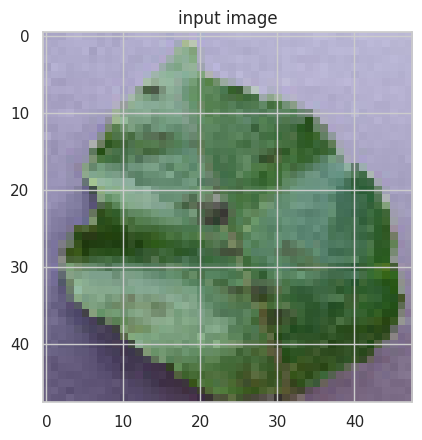

In [ ]:
path = r"/content/drive/MyDrive/color/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG"
img = image.load_img(path, target_size=(48,48) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(mob_model.predict(input_arr))

print("Predicted class:{}".format(enc.classes_[pred]))

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

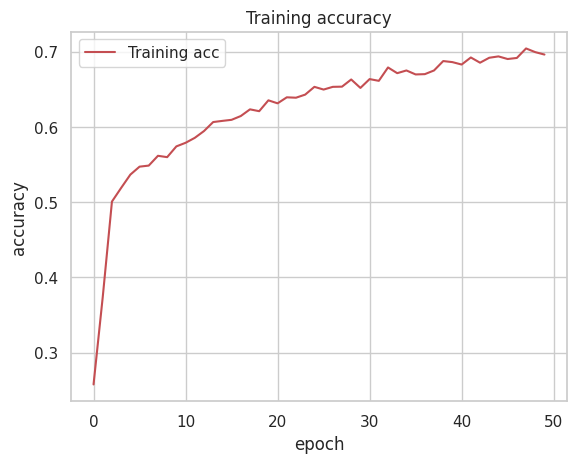

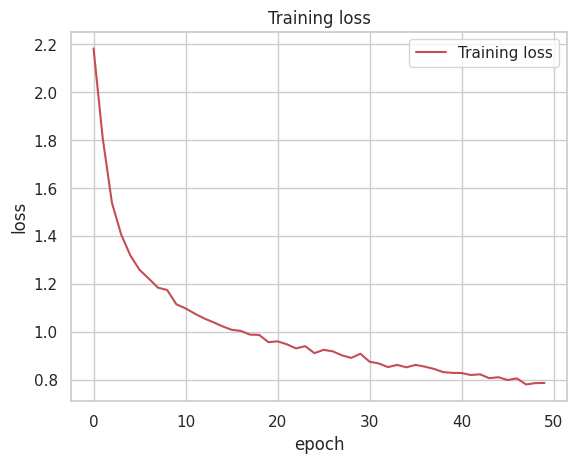

In [ ]:
acc = mob_his.history['accuracy']
loss = mob_his.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()